# Lineer Regresyon

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Dataset icin import ettik

from sympy import *

Islemlerimizde `seaborn` kutuphanesinde bulunan `"diamonds"` veri setini kullanacagiz.

In [2]:
sns.load_dataset('diamonds').sample(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
32294,0.30,Ideal,I,VS1,61.5,58.0,454,4.28,4.31,2.64
38542,0.34,Ideal,D,VS2,61.3,57.0,1033,4.50,4.47,2.75
26874,2.21,Premium,F,SI1,62.1,59.0,16804,8.33,8.26,5.15
35598,0.31,Ideal,H,VVS1,62.2,56.0,907,4.37,4.34,2.71
11193,1.00,Ideal,G,SI1,62.4,56.0,4956,6.41,6.34,3.98


Veri setinden;
- 150 ornek alip,
- carat ve price kolonlarini seciyoruz,
- satir numaralarini 0'dan baslatiyoruz.

In [3]:
np.random.seed(42)
df = sns.load_dataset('diamonds').sample(150)[['carat', 'price']].reset_index(drop=True)

In [4]:
df.head()

,carat,price
0,0.24,559
1,0.58,2201
2,0.40,1238
3,0.43,1304
4,1.55,6901


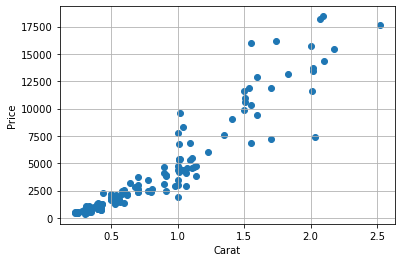

In [5]:
plt.scatter(df['carat'], df['price'])
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid();

In [6]:
J = Function("J")
a, b, m, i = symbols('a b m i')
X = IndexedBase('X')
Y = IndexedBase('Y')
Yhat = IndexedBase('Yhat')
maliyet = Eq(J(Yhat[i]), Sum((-Y[i] + Yhat[i])**2, (i, 0, m-1))/m/2)


Maliyet fonksiyonumuz:

In [7]:
display(maliyet)
display(Eq(Yhat[i], a*X[i] + b))
display(Eq(J(a, b), Sum((-Y[i] + a*X[i] + b)**2, (i, 0, m-1))/m/2))

Eq(J(Yhat[i]), Sum((-Y[i] + Yhat[i])**2, (i, 0, m - 1))/(2*m))

Eq(Yhat[i], a*X[i] + b)

Eq(J(a, b), Sum((a*X[i] + b - Y[i])**2, (i, 0, m - 1))/(2*m))

Bagimsiz degisken(ler): `X` ve bagimli degisken `y`.

- `X` ayni zamanda *dizayn matrisi* ya da *features* olarak da adlandirilmistir.
- `y` ayni zamanda *target* ya da *label* olarak da adlandirilmistir.

In [8]:
X = df['carat']
Y = df['price']

In [9]:
X.head()

0    0.24
1    0.58
2    0.40
3    0.43
4    1.55
Name: carat, dtype: float64

In [10]:
def maliyetOlustur(X, Y):
    """Verilen dataset icin maliyet hesabi yapan fonksiyon verir."""
    def J(a, b):
        """Verilen a ve b degerlerine gore maliyet hesabi yapar."""
        m = len(X)
        mse = sum([(a * X[i] + b - Y[i])**2 for i in range(m)]) / m
        return mse
    return J

In [11]:
J = maliyetOlustur(X, Y)

In [12]:
a = 0.
b = 0.
m = len(X)
alpha = 1e-1

In [13]:
J(0, 0)

35755873.27333333

In [14]:
da = sum([2 * (a*X[i] + b - Y[i]) * X[i] for i in range(m)]) / m
db = sum([2 * (a * X[i] + b - Y[i]) * 1 for i in range(m)]) / m

In [15]:
a = a - alpha * da
b = b - alpha * db

In [16]:
J(a, b)

20421552.127668835

In [17]:
Jt = []
at = [0., a]
bt = [0., b]
for i in range(100):
    da = sum([2 * (a*X[i] + b - Y[i]) * X[i] for i in range(m)]) / m
    db = sum([2 * (a * X[i] + b - Y[i]) * 1 for i in range(m)]) / m
    a = a - alpha * da
    b = b - alpha * db
    at += [a]
    bt += [b]
    Jt += [J(a, b)]

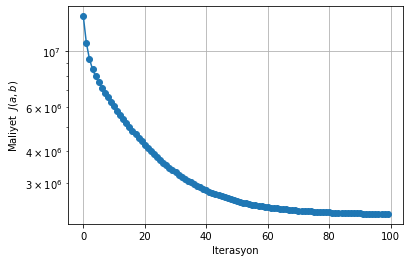

In [18]:
plt.plot(Jt, marker='o')
plt.semilogy()
plt.xlabel('Iterasyon')
plt.ylabel('Maliyet $\ J(a, b)$')
plt.grid();

In [19]:
aa, bb = np.meshgrid(np.linspace(-2000, 10000, 100), np.linspace(-10000, 5000, 100))
Jr = J(aa.ravel(), bb.ravel()).reshape(aa.shape)

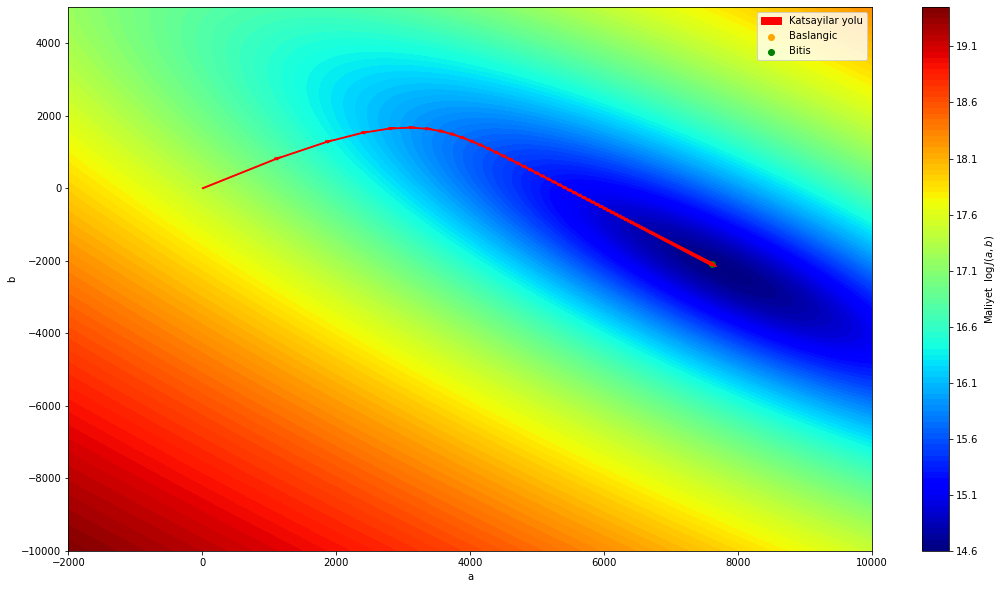

In [20]:
plt.figure(figsize=(18, 10))
plt.scatter(0, 0, color='orange', label='Baslangic')
plt.contourf(aa, bb, np.log(Jr), levels=100, cmap='jet')
plt.colorbar().set_label('Maliyet $\ \log{J(a, b)}$')
plt.xlabel('a')
plt.ylabel('b')
for i in range(len(at)-1):
    plt.arrow(at[i], bt[i], at[i+1] - at[i], bt[i+1] - bt[i], color='r', width=22, label=None if i>0 else "Katsayilar yolu")
plt.scatter(at[-1], bt[-1], color='green', label='Bitis')
plt.legend()


In [21]:
da

-66.95746835288736

In [22]:
db

64.46109283349004

In [23]:
class Model:
    """a ve b'yi tutan, kullaniciya tahmin icin bir metod saglayan bir class ornegi."""
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def predict(self, x):
        return self.a * x + self.b

In [24]:
# Sembolik degerlendirme.
m2 = Model(Symbol('a'), Symbol('b'))
m2.predict(Symbol('x'))

a*x + b

In [25]:
# Keyfi bir model olusturuyoruz.
m1 = Model(3, 4)
m1.predict(2)

10

In [26]:
class LineerRegresyon:
    """For donguleri ile kurulmus ilk lineer regresyon model sinifimiz.
    
    Parametreler:
    ----------
    alpha : float, default=1e-4
        Ogrenim katsayisi.
    tol : float, default=1e-4
        Hata toleransi. a ve b'nin turevi bu sayinin altina duserse iterasyon durdurulur.
    max_iter : int, default=1000
        Iterasyon sayisi. Bu sayida iterasyon yapilirsa algoritma durur.

    Notlar:
    ------
    Bu sinifin instance'i egit metodunu muteakip a ve b katsayilarini ogrenip saklar.
    
        
    """
    def __init__(self, alpha=1e-4, tol=1e-4, max_iter=1000):
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
        self.a = None
        self.b = None

    def egit(self, X, Y):
        a = 0
        b = 0
        m = len(X)
        
        iter_ = 0
        # iterasyon
        while True:
            da = sum([2 * (a*X[i] + b - Y[i]) * X[i] for i in range(m)]) / m
            db = sum([2 * (a * X[i] + b - Y[i]) * 1 for i in range(m)]) / m
            a = a - self.alpha * da
            b = b - self.alpha * db

            if (abs(da) < self.tol and abs(db) < self.tol) or iter_ >= self.max_iter:
                break

            iter_ += 1

        if iter_ >= self.max_iter:
            print("Max iter ulasildi.")
        a: float
        b: float

        self.a = a
        self.b = b

    def tahmin(self, x):
        return self.a * x + self.b


In [27]:
lr = LineerRegresyon(alpha=5e-1)
lr.egit(X, Y)

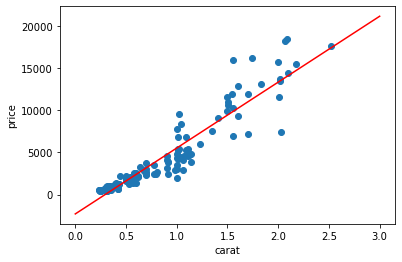

In [28]:
rng = np.linspace(0, 3, 1000)
plt.scatter(df['carat'], df['price'])
plt.plot(rng, [lr.tahmin(x) for x in rng], color='red')
plt.xlabel('carat')
plt.ylabel('price');

In [29]:
class LineerRegresyonV(LineerRegresyon):
    """LineerRegresyon sinifinin vektorize implementasyonu.
    
    Hipotez fonksiyonu ve turevler matrisler cinsinden ifade edilebiliyorsa bundan
    yararlanarak islemlerimizi hizlandirabiliriz.

    Ebeveyn sinifinin baslangic parametrelerini (alpha, tol, max_iter) kullanirken
    vektorize implementasyon icin `egit` ve `tahmin` metodlarini overload ederiz.

    Notlar:
    ------
    Bu sinifin instance'i egit metodunu muteakip A katsayi matrisini ogrenip saklar.
    """

    def xitemizle(self, X):
        """Verilen X matrisine sabit sayi 1 ekle.
        
        Intersept degeri, dizayn matrisi X'e sabit kolon 1 eklenerek elde edilebilir.
        Oyleyse bu sinifimizi coklu lineer regresyon icin de kullanamaz miyiz?
        
        """
        X = np.array(X)

        if X.ndim == 1:
            X = pd.DataFrame({'x': X}).assign(c=1).values
        else:
            X = pd.DataFrame(X).assign(c=1).values
        return X

    def egit(self, X, Y):
        X = self.xitemizle(X)
        
        m, n = X.shape

        A = np.random.randn(n, 1)
        Y = Y.values[:, None]

        dA = 2 * X.T @ (X @ A - Y) / m
        
        iter_ = 0
        # iterasyon
        while True:


            dA = 2 * X.T @ (X @ A - Y) / m
            self.dA = dA
            A = A - self.alpha * dA

            if (np.abs(dA) <= self.tol).all() or iter_ >= self.max_iter:
                break

            iter_ += 1

        if iter_ >= self.max_iter:
            print("Max iter ulasildi.")
        
        self.A = A

    def tahmin(self, X):
        X = self.xitemizle(X)
        return X @ self.A


Vektorize ve dongulu uygulamalar arasindaki zaman farki

In [30]:
%%time
lr = LineerRegresyon(alpha=5e-1)
lr.egit(X, Y)

Wall time: 233 ms


In [31]:
%%time
lrv = LineerRegresyonV(alpha=5e-1)
lrv.egit(X, Y)

Wall time: 2 ms


Sonucta ayni katsayilara erisiyoruz.

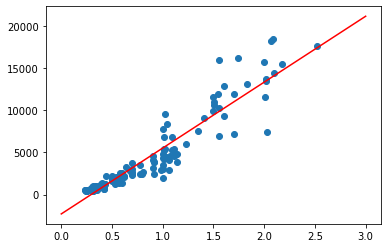

In [32]:
rng = np.linspace(0, 3, 1000)
plt.scatter(df['carat'], df['price'])
plt.plot(rng, lrv.tahmin(rng), color='red')

In [33]:
display((lr.a, lr.b))
display(lrv.A)

(7814.455658644848, -2289.1616562265035)

array([[ 7814.45565866],
       [-2289.16165624]])

## Coklu Lineer Regresyon

Basit lineer regresyonun lineer cebirsel gosteriminde sabit sayi ekleyerek yeni bir *feature* olusturmus ve problemi bu sekilde cozmustuk. Ayni prensibi var olan diger degiskenlere genisletebiliriz.

In [34]:
m, n, i, k = symbols('m n i k', integer=True)

X = MatrixSymbol('X', m, n)
A = MatrixSymbol('A', n, 1)
Y = MatrixSymbol('Y', m, 1)
b = IndexedBase('b')

Coklu lineer regresyonda her degiskenin kendine ait bir katsayisi olacaktir.

In [35]:
Eq(Yhat[i], Sum(X[i, k] * b[k+1], (k, 0, n-1)) + b[0])

Eq(Yhat[i], b[0] + Sum(b[k + 1]*X[i, k], (k, 0, n - 1)))

Vektorel gosterimde ise bir farklilik olmadigini goruyoruz:

$$\hat{Y} = X A$$

Bu calisma icin `carat` kolonuna ek olarak yeni *feature*'lar cekiyoruz.

In [36]:
np.random.seed(42)
df = sns.load_dataset('diamonds').sample(150)[['carat', 'depth', 'table', 'price']].reset_index(drop=True)

In [37]:
df.head()

,carat,depth,table,price
0,0.24,62.1,56.0,559
1,0.58,60.0,57.0,2201
2,0.40,62.1,55.0,1238
3,0.43,60.8,57.0,1304
4,1.55,62.3,55.0,6901


In [38]:
X = df[['carat', 'depth', 'table']]
Y = df['price']

In [39]:
coklu_lr = LineerRegresyonV(alpha=1.4e-4, max_iter=100_000, tol=1e-5)
coklu_lr.egit(X, Y)

Max iter ulasildi.


In [40]:
coklu_lr.dA

array([[-1.9907571 ],
       [-0.00938536],
       [ 0.06479962],
       [-1.50850574]])

Max iterasyon sonunda turevlerin tolerans altina dusmedigini goruyoruz.

Daha efektif (hizli ve stabil) bir optimizasyon icin degiskenleri ayni olcege getirmek faydali olabilir mi?

Bu uygulamada, pek cok olcekleme biciminden biri olan standardizasyonu kullaniyoruz:

$$x_n = (x - \bar{x})/s$$

In [41]:
Xnorm = (X - X.mean()) / X.std()

In [42]:
coklu_lr = LineerRegresyonV(alpha=1.4e-4, max_iter=100_000, tol=1e-4)
coklu_lr.egit(Xnorm, Y)

Olceklemeden sonra ayni iterasyon sayisi icerisinde turevler tolerans degerinin altina dustu.

In [43]:
coklu_lr.dA

array([[-3.15482540e-05],
       [ 9.24236879e-05],
       [ 9.99898404e-05],
       [-2.48404588e-08]])

### Coklu Lineer Regresyon ile tahmin

carat=0.29, depth=60.3, table=56 olan bir elmasin fiyatini tahmin etmek istiyoruz:

Coklu lineer regresyon modelimizi egitirken olceklenmis degiskenler kullanmistik.

In [44]:
coklu_lr.tahmin([[0.29, 60.3, 56]]) # Hata !

array([[-5498.73790574]])

Dolayisiyla tahminleri de ayni ortalama ve standart sapma ile olceklenmis girdiler uzerinde yapmaliyiz.

Ornek olcekleme:
> Egitim verisini olceklemede kullanilan ortalama ve standart sapmanin kullanildigina dikkat ediniz.

In [45]:
(np.array([[0.29, 60.3, 56]]) - X.mean().values) / X.std().values

array([[-0.98181704, -1.01579889, -0.5267022 ]])

In [46]:
coklu_lr.tahmin((np.array([[0.29, 60.3, 56]]) - X.mean().values) / X.std().values) # Olceklenmis deger ile dogru tahmin

array([[59.92621708]])

In [47]:
coklu_lr.A

array([[4175.38183272],
       [ -16.07742302],
       [-174.84101242],
       [4050.96666665]])

Lineer regresyonda girdilerin sabit sayilarla olceklenmesi sonucu degistirmeyecektir. Asagida keyfi bir olcekleme goruyorsunuz:

In [48]:
coklu_lr2 = LineerRegresyonV(alpha=1.4e-2, max_iter=400_000, tol=1e-4)
coklu_lr2.egit(Xnorm / 19 + 0.2, Y)

Bulunan katsayilar farkli:

In [49]:
coklu_lr2.A

array([[ 79332.24910393],
       [  -305.4424008 ],
       [ -3321.94926283],
       [-11090.00483894]])

Alinan sonuc ise ayni:

In [50]:
coklu_lr2.tahmin((np.array([[0.29, 60.3, 56]]) - X.mean().values) / X.std().values / 19 + 0.2)

array([[59.92413311]])

### Hazir kutuphaneler

In [51]:
from sklearn import linear_model

Modelin kurulmasi

In [52]:
model = linear_model.LinearRegression()
model.fit(X, Y)

LinearRegression()

Tahminleme

In [53]:
model.predict(np.array([[0.29, 60.3, 56]]))

c:\Users\berk_\miniconda3\envs\cons1\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([59.92631255])

Katsayilar:

In [54]:
model.coef_

array([7863.41633622,  -10.86834918,  -78.88851211])

Intersept:

In [55]:
model.intercept_

2852.6537084937095

Yazdigimiz class ile sklearn `LinearRegression` modellerinin MSE'leri ayni:

In [56]:
((coklu_lr.tahmin(Xnorm).ravel() - Y)**2).mean()

2215053.243448922

In [57]:
((model.predict(X) - Y)**2).mean()

2215053.243448913

Optimizasyon dogru sekilde icra edildiginde lineer regresyonun bu veri seti uzerinde saglayabilecegi maksimum performansa ulasiyoruz,

### Polinomiyel Regresyon

Farkli degiskenleri kullanarak coklu lineer regresyon yaptigimiz gibi, ayni mantigi degiskenlerin polinomiyellerine de genisletebiliriz.

$$fiyat = (a) (carat^2) + (b) (carat) + (c)$$

Hipotezimizde kullandigimiz katsayilarin (a, b, c) hala birinci dereceden olduguna, `carat` ve `carat^2`'nin ise yalnizca yerine konulmasi gereken bilinen degerler olduguna dikkat ediniz.

In [58]:
X['carat^2'] = X['carat']**2

In [59]:
pol = linear_model.LinearRegression()
pol.fit(X[['carat', 'carat^2']], Y)

LinearRegression()

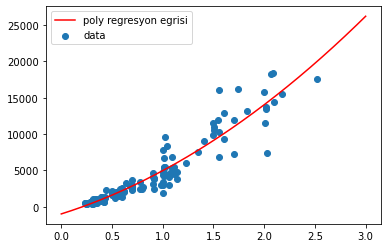

In [60]:
rng = np.linspace(0, 3, 1000)
plt.scatter(df['carat'], df['price'], label='data')
plt.plot(rng, pol.predict(pd.DataFrame({"carat": rng, "carat^2": rng**2})), color='red', label='poly regresyon egrisi')
plt.legend();

`carat` ve `carat^2` uzayinda tahminlerimiz hala lineer.

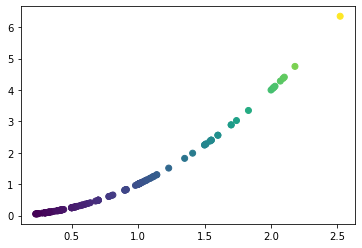

In [61]:
plt.scatter(df['carat'], df['carat']**2, c=pol.predict(X[['carat', 'carat^2']]))

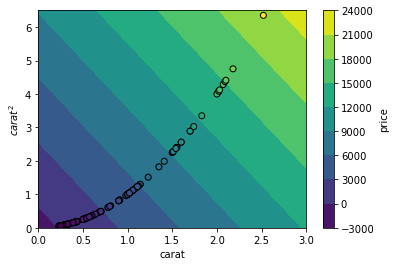

In [62]:
aa, bb = np.meshgrid(np.linspace(0, 3, 100), np.linspace(0, 6.5, 100))
zz = pol.predict(pd.DataFrame(np.array([aa.ravel(), bb.ravel()]).T, columns=['carat', 'carat^2'])).reshape(aa.shape)
plt.contourf(aa, bb, zz)
plt.colorbar().set_label("price")
plt.xlabel('carat')
plt.ylabel('$carat^2$')
plt.scatter(df['carat'], df['carat']**2, c=pol.predict(X[['carat', 'carat^2']]), edgecolors='k');

##### Polinomiyel degiskenler icin onisleme

In [63]:
from sklearn import preprocessing

In [64]:
poly = preprocessing.PolynomialFeatures(32)

Egitim seti uzerinde en az hatayi veren model, gercekten de en iyi model midir?

In [65]:
Xp = poly.fit_transform(X[['carat']])

In [66]:
model_16 = linear_model.LinearRegression()
model_16.fit(Xp[:20], Y[:20])

LinearRegression()

In [67]:
model_16.score(Xp[:20], Y[:20])

0.9746846742098081

In [68]:
from sklearn import metrics

In [69]:
metrics.mean_squared_error(Y[:20], model_16.predict(Xp[:20]))

319355.3442882283

Egitim seti uzerinde gorunur modelleme mukemmele yakin (MSE ve R2 skoru acilarindan), ancak modelin cizmis oldugu egri akla yatkin degil.

c:\Users\berk_\miniconda3\envs\cons1\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


(0.0, 40000.0)

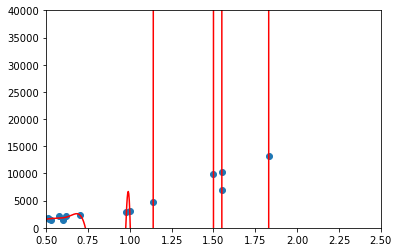

In [70]:
rng = np.linspace(0, 3, 1000)
plt.scatter(df['carat'][:20], df['price'][:20])
plt.plot(rng, model_16.predict(poly.transform(rng[:, None])), color='red')
plt.xlim(0.5, 2.5)
plt.ylim(0, 40000)

In [71]:
poly3 = preprocessing.PolynomialFeatures(3)
Xp = poly3.fit_transform(X[['carat']])
model_3 = linear_model.LinearRegression()
model_3.fit(Xp[:20], Y[:20])

LinearRegression()

In [72]:
model_3.score(Xp[:20], Y[:20])

0.9584429429617666

In [73]:
metrics.mean_squared_error(Y[:20], model_3.predict(Xp[:20]))

524246.3939844867

3. dereceden polinomiyel ile calisan modelimiz ise gorunurde MSE ve R2 skorlari olarak daha dusuk performans vermesine ragmen genel trendi takip eden bir egre cizmektedir.

c:\Users\berk_\miniconda3\envs\cons1\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


(0.0, 40000.0)

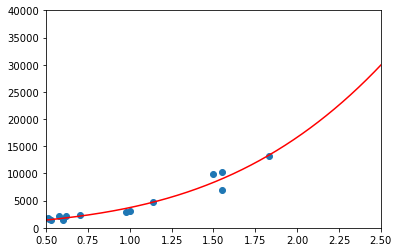

In [74]:
rng = np.linspace(0, 3, 1000)
plt.scatter(df['carat'][:20], df['price'][:20])
plt.plot(rng, model_3.predict(poly3.transform(rng[:, None])), color='red')
plt.xlim(0.5, 2.5)
plt.ylim(0, 40000)

>**SORU**: Egitim seti uzerindeki performans tek basina basari gostergesi degilse modelleri nasil kiyaslayabiliriz?

### Cozum: Test seti

Elimizdeki verinin bir kismini modele gostermeyip test maksadiyla saklayabiliriz.

- Model egitim verisini ezberliyor mu?
- Yoksa genel trendi modellemeyi basarabiliyor mu?

Ilk 16 veriyi egitim icin kullaniyoruz:

In [75]:
model_16.fit(poly.transform(X[['carat']])[:16], Y[:16])
model_16.score(poly.transform(X[['carat']])[:16], Y[:16])

0.9683258334375823

In [76]:
metrics.mean_squared_error(Y[:16], model_16.predict(poly.transform(X[['carat']])[:16]))

391624.0633580294

Modele gostermedigimiz son 4 veri uzerinde ise modelimizi test ediyoruz.

- Test R2 skoru:

In [77]:
model_16.score(poly.transform(X[['carat']])[16:20], Y[16:20])

-2086535275586217.2

Poly(3) icin egitim ve test basarilari:

Egitim

In [78]:
model_3.fit(poly3.transform(X[['carat']])[:16], Y[:16])
model_3.score(poly3.transform(X[['carat']])[:16], Y[:16])

0.9654945246861223

In [79]:
metrics.mean_absolute_percentage_error(Y[:16], model_3.predict(poly3.transform(X[['carat']])[:16]))

0.1336181330264758

In [80]:
metrics.mean_absolute_percentage_error(
    Y[:16], 
    model_3.predict(poly3.transform(X[['carat']])[:16]),
    sample_weight=Y[:16])

0.11793248386570307

In [81]:
metrics.mean_squared_error(Y[:16], model_3.predict(poly3.transform(X[['carat']])[:16]))

426630.7820252089

Test:

In [82]:
model_3.score(poly3.transform(X[['carat']])[16:20], Y[16:20])

0.9177484276869028